In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import mean_squared_error

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import vstack, issparse
import importlib
import functions

importlib.reload(functions)

pd.set_option('display.max_columns', None)

In [121]:
df = pd.read_csv('data/dataset_workout.csv')
df.head(3)

,Gender,Weight (kg),Height (m),Calories_Burned,Workout_Type,Water_Intake (liters),Workout_Frequency (days),Daily meals frequency,diet_type,rating,Name of Exercise,Sets,Reps,Benefit,Target Muscle Group,Equipment Needed,Body Part,Type of Muscle,Workout,cluster_id,E,I,S,D,R
0,Male,65.27,1.62,1080.90,Strength,1.50,4,3,Vegan,1.31,Decline Push-ups,5,21,Improves shoulder health and posture,"Shoulders, Triceps",Cable Machine,Legs,Lats,Dumbbell flyes,2,0.570217,0.526466,0.250000,0.333333,0.637310
1,Female,56.41,1.55,1809.91,HIIT,1.90,4,3,Vegetarian,1.92,Bear Crawls,4,16,Strengthens lower abs,"Back, Core, Shoulders",Step or Box,Chest,Lats,Lateral raises,2,0.740993,0.256055,0.225000,0.575163,0.862514
2,Female,58.98,1.67,802.26,Cardio,1.88,3,2,Paleo,4.70,Dips,5,22,Builds chest strength,"Quadriceps, Glutes",Step or Box,Arms,Grip Strength,Standing calf raises,1,0.549660,0.289199,0.416667,0.274510,0.685580


In [122]:
user = pd.read_csv('data/new_user.csv')
user_full = user.copy()
user

,Age,Gender,Weight (kg),Height (m),BMI,Experience_Level,Workout_Frequency (days),Daily meals frequency,diet_type,Goal,WeightChange (kg),GoalDays,cluster_id,BMR,PAL,TDEE,CalorieChange,CaloriesToBurnTraining,CaloriesReducedFromFood,CaloriesPerDay,TotalWorkouts,CaloriesPerWorkout
0,20,Female,55.0,1.7,19.031142,2,2,3,Balanced,Maintain,0,14,1,1351.5,1.55,2094.825,0.0,29327.55,0.0,2094.825,4.0,7331.8875


### Target calculation depending on goal from user

In [123]:
goal = user['Goal'].iloc[0]

if goal == 'Loss':
    df['target'] = 0.45*df['E'] + 0.25*df['I'] + 0.10*df['D'] + 0.05*df['S'] + 0.15*df['R']
elif goal == 'Maintain':
    df['target'] = 0.25*df['E'] + 0.20*df['I'] + 0.15*df['D'] + 0.20*df['S'] + 0.20*df['R']
elif goal == 'Gain':
    df['target'] = 0.05*df['E'] + 0.15*df['I'] + 0.10*df['D'] + 0.50*df['S'] + 0.20*df['R']
else:
    raise ValueError("Goal must be one of: 'Loss', 'Maintain', 'Gain'")

In [124]:
df.head(3)

,Gender,Weight (kg),Height (m),Calories_Burned,Workout_Type,Water_Intake (liters),Workout_Frequency (days),Daily meals frequency,diet_type,rating,Name of Exercise,Sets,Reps,Benefit,Target Muscle Group,Equipment Needed,Body Part,Type of Muscle,Workout,cluster_id,E,I,S,D,R,target
0,Male,65.27,1.62,1080.90,Strength,1.50,4,3,Vegan,1.31,Decline Push-ups,5,21,Improves shoulder health and posture,"Shoulders, Triceps",Cable Machine,Legs,Lats,Dumbbell flyes,2,0.570217,0.526466,0.250000,0.333333,0.637310,0.475309
1,Female,56.41,1.55,1809.91,HIIT,1.90,4,3,Vegetarian,1.92,Bear Crawls,4,16,Strengthens lower abs,"Back, Core, Shoulders",Step or Box,Chest,Lats,Lateral raises,2,0.740993,0.256055,0.225000,0.575163,0.862514,0.540237
2,Female,58.98,1.67,802.26,Cardio,1.88,3,2,Paleo,4.70,Dips,5,22,Builds chest strength,"Quadriceps, Glutes",Step or Box,Arms,Grip Strength,Standing calf raises,1,0.549660,0.289199,0.416667,0.274510,0.685580,0.456880


### Training dataset preparation

In [125]:
# Drop target construction components
df = df.drop(columns=['E', 'I', 'D', 'S', 'R'])
df.head(3)

,Gender,Weight (kg),Height (m),Calories_Burned,Workout_Type,Water_Intake (liters),Workout_Frequency (days),Daily meals frequency,diet_type,rating,Name of Exercise,Sets,Reps,Benefit,Target Muscle Group,Equipment Needed,Body Part,Type of Muscle,Workout,cluster_id,target
0,Male,65.27,1.62,1080.90,Strength,1.50,4,3,Vegan,1.31,Decline Push-ups,5,21,Improves shoulder health and posture,"Shoulders, Triceps",Cable Machine,Legs,Lats,Dumbbell flyes,2,0.475309
1,Female,56.41,1.55,1809.91,HIIT,1.90,4,3,Vegetarian,1.92,Bear Crawls,4,16,Strengthens lower abs,"Back, Core, Shoulders",Step or Box,Chest,Lats,Lateral raises,2,0.540237
2,Female,58.98,1.67,802.26,Cardio,1.88,3,2,Paleo,4.70,Dips,5,22,Builds chest strength,"Quadriceps, Glutes",Step or Box,Arms,Grip Strength,Standing calf raises,1,0.456880


In [126]:
numerical_features = [
    'Weight (kg)', 'Height (m)',
    'Workout_Frequency (days)', 'Daily meals frequency', 'rating'
]
categorical_features = [
    'Gender', 'Workout_Type', 'diet_type', 'Name of Exercise', 'Benefit',
    'Target Muscle Group', 'Equipment Needed', 'Body Part',
    'Type of Muscle', 'Workout', 'cluster_id'
]

In [127]:
selected_features = numerical_features + categorical_features + ['target']
 
# -------------------------------
# create df_selected
# calories_burned is NOT included here
# -------------------------------
df_selected = df[selected_features].copy()
df_selected.head(3)

,Weight (kg),Height (m),Workout_Frequency (days),Daily meals frequency,rating,Gender,Workout_Type,diet_type,Name of Exercise,Benefit,Target Muscle Group,Equipment Needed,Body Part,Type of Muscle,Workout,cluster_id,target
0,65.27,1.62,4,3,1.31,Male,Strength,Vegan,Decline Push-ups,Improves shoulder health and posture,"Shoulders, Triceps",Cable Machine,Legs,Lats,Dumbbell flyes,2,0.475309
1,56.41,1.55,4,3,1.92,Female,HIIT,Vegetarian,Bear Crawls,Strengthens lower abs,"Back, Core, Shoulders",Step or Box,Chest,Lats,Lateral raises,2,0.540237
2,58.98,1.67,3,2,4.70,Female,Cardio,Paleo,Dips,Builds chest strength,"Quadriceps, Glutes",Step or Box,Arms,Grip Strength,Standing calf raises,1,0.456880


In [128]:
# =========================
# 3) Split X/y (Train / Val / Test)
# =========================
X = df_selected.drop(columns=["target"])
y = df_selected["target"]

# 70% train, 15% val, 15% test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42
)

In [129]:
# =========================
# 4) One-hot encoding (fit on train only, transform val/test)
# =========================
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", "passthrough", numerical_features),
    ],
    remainder="drop"
)

X_train_enc = preprocess.fit_transform(X_train)
X_val_enc   = preprocess.transform(X_val)
X_test_enc  = preprocess.transform(X_test)

# Helper function (RMSE)
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


### Baseline model: Linear Regression

In [130]:
# ============================================================
# SECTION 1: BASELINE MODEL (Linear Regression baseline)
# ============================================================
baseline_lr = LinearRegression()
baseline_lr.fit(X_train_enc, y_train)

val_pred_lr = baseline_lr.predict(X_val_enc)
val_rmse_lr = rmse(y_val, val_pred_lr)

print(f"[Baseline] Validation RMSE (Linear Regression): {val_rmse_lr:.6f}")

[Baseline] Validation RMSE (Linear Regression): 0.084577


### Main model: XGBoost

In [131]:
# ============================================================
# SECTION 2: MODEL WITH MANUAL HYPERPARAMETERS (manual n_estimators selection)
# ============================================================
n_estimators_list = [50, 100, 200, 300, 500]
manual_results = []

for n in n_estimators_list:
    xgb_manual_candidate = XGBRegressor(
        n_estimators=n,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        random_state=42,
        n_jobs=-1
    )
    xgb_manual_candidate.fit(X_train_enc, y_train)
    val_pred = xgb_manual_candidate.predict(X_val_enc)
    manual_results.append((n, rmse(y_val, val_pred)))

best_n_estimators, best_val_rmse_manual = min(manual_results, key=lambda x: x[1])

print(f"[Manual HP] Best n_estimators: {best_n_estimators}")
print(f"[Manual HP] Validation RMSE: {best_val_rmse_manual:.6f}")


[Manual HP] Best n_estimators: 500
[Manual HP] Validation RMSE: 0.069014


In [132]:
# Train the "manual HP model" on train only (classical)
xgb_manual_best = XGBRegressor(
    n_estimators=best_n_estimators,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)
xgb_manual_best.fit(X_train_enc, y_train)

test_pred_manual = xgb_manual_best.predict(X_test_enc)
test_rmse_manual = rmse(y_test, test_pred_manual)
print(f"[Manual HP] Test RMSE: {test_rmse_manual:.6f}")


[Manual HP] Test RMSE: 0.070777


### Hyperparameter tuning

In [133]:
# ============================================================
# SECTION 3: MODEL WITH TUNED HYPERPARAMETERS (RandomizedSearchCV on TRAIN only)
# ============================================================
xgb_base = XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)

param_distributions = {
    "n_estimators": [100, 200, 300, 500, 800, 1200],
    "learning_rate": [0.01, 0.03, 0.05, 0.08, 0.1, 0.2],
    "max_depth": [2, 3, 4, 5, 6, 8],
    "min_child_weight": [1, 2, 5, 10],
    "subsample": [0.6, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.6, 0.8, 0.9, 1.0],
    "gamma": [0, 0.1, 0.3, 0.5, 1.0],
    "reg_alpha": [0, 1e-4, 1e-3, 1e-2, 0.1, 1.0],
    "reg_lambda": [0.5, 1.0, 2.0, 5.0, 10.0],
}

search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_distributions,
    n_iter=40,
    scoring="neg_mean_squared_error",
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# IMPORTANT: Fit on TRAIN only 
search.fit(X_train_enc, y_train)

best_params = search.best_params_
best_cv_rmse = np.sqrt(-search.best_score_)

print("[Tuned HP] Best CV params:", best_params)
print(f"[Tuned HP] Best CV RMSE: {best_cv_rmse:.6f}")

# evaluate tuned model on VALIDATION as a holdout check
xgb_tuned_train_only = XGBRegressor(
    **best_params,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)
xgb_tuned_train_only.fit(X_train_enc, y_train)

val_pred_tuned = xgb_tuned_train_only.predict(X_val_enc)
val_rmse_tuned = rmse(y_val, val_pred_tuned)
print(f"[Tuned HP] Validation RMSE (holdout check): {val_rmse_tuned:.6f}")



Fitting 5 folds for each of 40 candidates, totalling 200 fits
[Tuned HP] Best CV params: {'subsample': 0.9, 'reg_lambda': 0.5, 'reg_alpha': 0.01, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.08, 'gamma': 0, 'colsample_bytree': 0.9}
[Tuned HP] Best CV RMSE: 0.065314
[Tuned HP] Validation RMSE (holdout check): 0.062781


In [134]:
# ============================================================
# SECTION 4: FINAL MODEL (best tuned hyperparams substituted)
# Classical step: train on TRAIN+VAL, then test once
# ============================================================
# Combine train + val encoded matrices
if issparse(X_train_enc) or issparse(X_val_enc):
    X_trainval_enc = vstack([X_train_enc, X_val_enc])
else:
    X_trainval_enc = np.vstack([X_train_enc, X_val_enc])

y_trainval = np.concatenate([y_train.to_numpy(), y_val.to_numpy()])

final_model = XGBRegressor(
    **best_params,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)
final_model.fit(X_trainval_enc, y_trainval)

test_pred_final = final_model.predict(X_test_enc)
test_rmse_final = rmse(y_test, test_pred_final)
print(f"[FINAL] Test RMSE (trained on train+val): {test_rmse_final:.6f}")

[FINAL] Test RMSE (trained on train+val): 0.063086


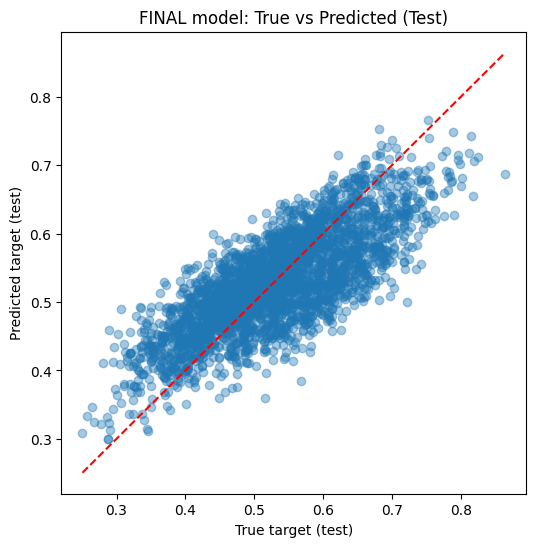

In [135]:
# ============================================================
# SECTION 5: VISUALIZATIONS (with FINAL model)
# Use TEST for unbiased visual diagnostics
# ============================================================
# True vs Predicted (TEST)
plt.figure(figsize=(6, 6))
plt.scatter(y_test, test_pred_final, alpha=0.4)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         "r--")
plt.xlabel("True target (test)")
plt.ylabel("Predicted target (test)")
plt.title("FINAL model: True vs Predicted (Test)")
plt.show()


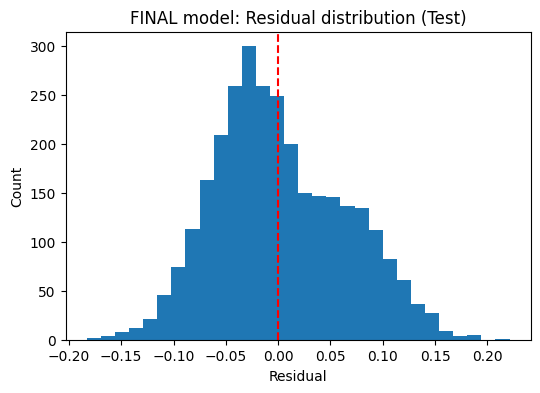

In [136]:
# Residuals (TEST)
test_residuals = y_test - test_pred_final

plt.figure(figsize=(6, 4))
plt.hist(test_residuals, bins=30)
plt.axvline(0, color="red", linestyle="--")
plt.title("FINAL model: Residual distribution (Test)")
plt.xlabel("Residual")
plt.ylabel("Count")
plt.show()


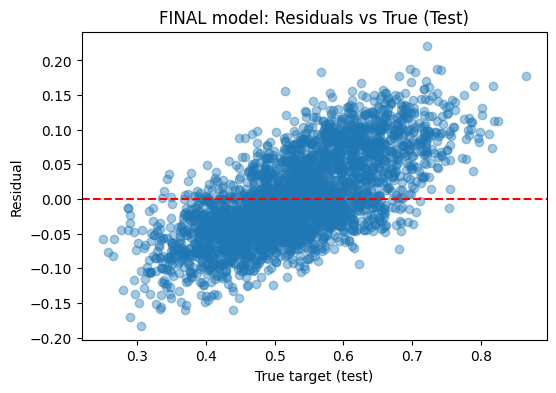

In [137]:
plt.figure(figsize=(6, 4))
plt.scatter(y_test, test_residuals, alpha=0.4)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("True target (test)")
plt.ylabel("Residual")
plt.title("FINAL model: Residuals vs True (Test)")
plt.show()

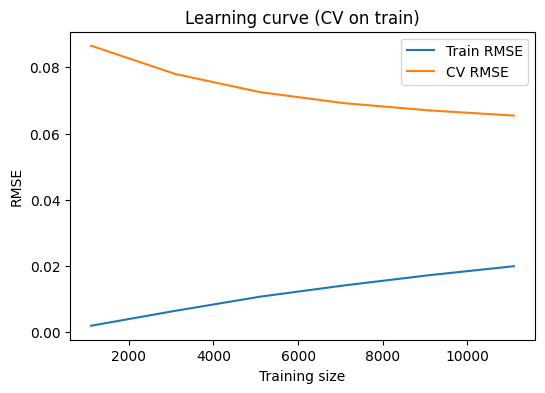

In [138]:
# Learning curve (on TRAIN only; CV inside)
est_for_curve = XGBRegressor(
    **best_params,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)

train_sizes, train_scores, val_scores = learning_curve(
    est_for_curve,
    X_train_enc,
    y_train,
    cv=5,
    scoring="neg_mean_squared_error",
    train_sizes=np.linspace(0.1, 1.0, 6),
    n_jobs=-1
)

train_rmse_curve = np.sqrt(-train_scores.mean(axis=1))
val_rmse_curve   = np.sqrt(-val_scores.mean(axis=1))

plt.figure(figsize=(6, 4))
plt.plot(train_sizes, train_rmse_curve, label="Train RMSE")
plt.plot(train_sizes, val_rmse_curve, label="CV RMSE")
plt.xlabel("Training size")
plt.ylabel("RMSE")
plt.title("Learning curve (CV on train)")
plt.legend()
plt.show()

#### Save the model and encoder

In [139]:
joblib.dump(preprocess, "encoder.pkl")
joblib.dump(final_model, "models/workout_model.pkl")

['models/workout_model.pkl']

### Create testing data

In [140]:
user_full = user.copy()
user = user.drop(
                    columns=['Age', 'Experience_Level', 'Goal', 'WeightChange (kg)', 'GoalDays', 'BMR', 'PAL', 'TDEE', 'CalorieChange', 'CaloriesToBurnTraining', 
                        'CaloriesReducedFromFood', 'CaloriesPerDay',  'TotalWorkouts', 'CaloriesPerWorkout', "BMI"]
                )

In [141]:
user

,Gender,Weight (kg),Height (m),Workout_Frequency (days),Daily meals frequency,diet_type,cluster_id
0,Female,55.0,1.7,2,3,Balanced,1


In [142]:
# Exercise-related features
exercise_df_full = df[
                    ['Sets', 'Reps', 'rating', 'Workout_Type', 'Name of Exercise', 'Benefit',
                        'Target Muscle Group', 'Equipment Needed', 'Body Part',
                        'Type of Muscle', 'Workout', 'Calories_Burned']
].reset_index(drop=True)
 
exercise_df_cleaned = exercise_df_full.drop(columns=['Sets', 'Reps', 'Calories_Burned'])
 
# Repeat user row to match number of exercises
workout_predict_cleaned = pd.concat(
    [pd.concat([user] * len(exercise_df_cleaned), ignore_index=True), exercise_df_cleaned],
    axis=1
)
 
workout_predict_full = pd.concat(
    [pd.concat([user] * len(exercise_df_full), ignore_index=True), exercise_df_full],
    axis=1
)
 
workout_predict_cleaned.head(3)

,Gender,Weight (kg),Height (m),Workout_Frequency (days),Daily meals frequency,diet_type,cluster_id,rating,Workout_Type,Name of Exercise,Benefit,Target Muscle Group,Equipment Needed,Body Part,Type of Muscle,Workout
0,Female,55.0,1.7,2,3,Balanced,1,1.31,Strength,Decline Push-ups,Improves shoulder health and posture,"Shoulders, Triceps",Cable Machine,Legs,Lats,Dumbbell flyes
1,Female,55.0,1.7,2,3,Balanced,1,1.92,HIIT,Bear Crawls,Strengthens lower abs,"Back, Core, Shoulders",Step or Box,Chest,Lats,Lateral raises
2,Female,55.0,1.7,2,3,Balanced,1,4.70,Cardio,Dips,Builds chest strength,"Quadriceps, Glutes",Step or Box,Arms,Grip Strength,Standing calf raises


In [143]:
preprocess = joblib.load("encoder.pkl")
final_model = joblib.load("models/workout_model.pkl")

workout_predict_enc = preprocess.transform(workout_predict_cleaned)
predictions = final_model.predict(workout_predict_enc)

In [144]:
# Add predictions as a new column
workout_predict_full["workout_score"] = predictions
 
workout_predict_full.head(3)

,Gender,Weight (kg),Height (m),Workout_Frequency (days),Daily meals frequency,diet_type,cluster_id,Sets,Reps,rating,Workout_Type,Name of Exercise,Benefit,Target Muscle Group,Equipment Needed,Body Part,Type of Muscle,Workout,Calories_Burned,workout_score
0,Female,55.0,1.7,2,3,Balanced,1,5,21,1.31,Strength,Decline Push-ups,Improves shoulder health and posture,"Shoulders, Triceps",Cable Machine,Legs,Lats,Dumbbell flyes,1080.90,0.524031
1,Female,55.0,1.7,2,3,Balanced,1,4,16,1.92,HIIT,Bear Crawls,Strengthens lower abs,"Back, Core, Shoulders",Step or Box,Chest,Lats,Lateral raises,1809.91,0.463783
2,Female,55.0,1.7,2,3,Balanced,1,5,22,4.70,Cardio,Dips,Builds chest strength,"Quadriceps, Glutes",Step or Box,Arms,Grip Strength,Standing calf raises,802.26,0.432803


#### Top 100 most suitable exercises based on user profile and goal & Recommendation system

Why this is “classical recommender way”

This matches standard recommender architecture:

1) Candidate generation

Top-100 by predicted relevance (workout_score)

2) Content embedding

TF-IDF vectors from exercise metadata

3) Similarity-based grouping

Cosine similarity to “day prototypes” (a standard content-based trick)

4) Reranking for diversity

MMR is a classic diversification algorithm used in recommender systems.

In [145]:
# ----------------------------
# 1) Candidate generation: Top N
# ----------------------------
TOP_N = 100
candidates = (
    workout_predict_full
    .sort_values("workout_score", ascending=False)
    .head(TOP_N)
    .reset_index(drop=True)
    .copy()
)
                       
                        
# ----------------------------
# 2) Build text for vectorization (classic content-based)
# ----------------------------
TEXT_COLS = ["Benefit", "Target Muscle Group", "Equipment Needed", "Workout", "Body Part", "Type of Muscle", "Workout_Type", "Name of Exercise"]

def make_text_profile(df: pd.DataFrame, cols=TEXT_COLS) -> pd.Series:
    tmp = df[cols].copy()
    for c in cols:
        tmp[c] = (tmp[c].astype(str).fillna("")
                  .str.lower()
                  .str.replace(r"\s+", " ", regex=True)
                  .str.strip())
    return tmp.apply(lambda r: " ".join([v for v in r.values if v and v != "nan"]), axis=1)

exercise_text = make_text_profile(candidates)

# TF-IDF vectors for exercises
vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=1, max_features=5000)
X_ex = vectorizer.fit_transform(exercise_text)

# ----------------------------
# 3) Create "day prototypes" as text -> vector 
# ----------------------------
day_prototypes = {
    "Legs": "legs lower body quads quadriceps hamstrings glutes calves posterior",
    "Push": "chest shoulders triceps upper chest pressing push",
    "Pull": "back lats upper back biceps rows pull",
    "Core": "abs core obliques plank dead bug flutter kicks",
}

proto_text = list(day_prototypes.values())
X_proto = vectorizer.transform(proto_text)  # same vector space

# similarity of each exercise to each day prototype
S_day = cosine_similarity(X_ex, X_proto)   # shape: (n_exercises, 4)

day_names = list(day_prototypes.keys())
candidates["day_label"] = [day_names[i] for i in np.argmax(S_day, axis=1)]
candidates["day_sim"] = np.max(S_day, axis=1)  # confidence (how strongly it matches)

# ----------------------------
# 4) MMR reranking: relevant + diverse inside each day
# ----------------------------
def mmr_select_calories(df_day: pd.DataFrame, X_day_vecs, calories_target, k=4, alpha=0.75):
    if len(df_day) == 0:
        return df_day

    # normalize
    rel = df_day["workout_score"].to_numpy()
    rel = (rel - rel.min()) / (rel.max() - rel.min() + 1e-9)

    selected_idx = []
    remaining = list(range(len(df_day)))
    sims = cosine_similarity(X_day_vecs, X_day_vecs)

    current_calories = 0.0

    while remaining and len(selected_idx) < k and current_calories < calories_target:
        if not selected_idx:
            best = remaining[int(np.argmax(rel[remaining]))]
        else:
            mmr_scores = []
            for i in remaining:
                max_sim_to_selected = np.max(sims[i, selected_idx]) if selected_idx else 0
                mmr = alpha * rel[i] - (1-alpha) * max_sim_to_selected
                mmr_scores.append(mmr)
            best = remaining[int(np.argmax(mmr_scores))]

        selected_idx.append(best)
        current_calories += df_day.iloc[best]["Calories_Burned"]  # summing calories burned
        remaining.remove(best)

        if current_calories >= calories_target:
            break  # if reached target workout calories (per day)

    return df_day.iloc[selected_idx].copy()

# ----------------------------
# 5) Plan Generation TotalWorkouts
# ----------------------------
plan = []
for day in range(int(user_full.TotalWorkouts.iloc[0])):
    day_label = day_names[day % len(day_names)]
    df_day = candidates[candidates["day_label"] == day_label].copy()
    idx = df_day.index.to_numpy()
    X_day = X_ex[idx]

    day_plan = mmr_select_calories(df_day, X_day, calories_target=user_full.CaloriesPerWorkout.iloc[0], k=4, alpha=0.75)
    plan.append((day_label, day_plan))

# ----------------------------
# 6) Output
# ----------------------------
cols_show = ['Workout_Type', 'Workout', 'Name of Exercise', 'Body Part',
             'Target Muscle Group', 'Equipment Needed', 'Sets', 'Reps', 'Type of Muscle', 'Benefit', 'Calories_Burned']

for day_label, day_plan in plan:
    print(f"\n===== {day_label} Day =====")
    display(day_plan[cols_show].reset_index(drop=True))

# Check
total_burned = sum(day_plan["Calories_Burned"].sum() for _, day_plan in plan)
print(f"\nTotal burned calories across all days: {total_burned:.2f} (Target: {user_full.CaloriesToBurnTraining.iloc[0]:.2f})")
print("Difference:", round(total_burned - user_full.CaloriesToBurnTraining.iloc[0], 1))



===== Legs Day =====


,Workout_Type,Workout,Name of Exercise,Body Part,Target Muscle Group,Equipment Needed,Sets,Reps,Type of Muscle,Benefit,Calories_Burned
0,HIIT,Standing calf raises,Bicycle Crunches,Legs,"Back, Hamstrings, Glutes",Dumbbells,5,21,Grip Strength,Strengthens triceps and chest,1586.54
1,HIIT,Incline cable crossovers,Dragon Flags,Legs,Quadriceps,"Bench, Barbell",5,21,Posterior,Full body workout,1574.43
2,Strength,Towel pull-up,Zottman Curls,Arms,"Glutes, Hamstrings",Resistance Band or Cable Machine,5,25,Grip Strength,Targets obliques and improves core rotation,1380.10
3,Cardio,Leg curls,Step-ups,Forearms,Triceps,Dumbbells or Barbell,5,25,Posterior,Builds lower body power and endurance,1216.15



===== Push Day =====


,Workout_Type,Workout,Name of Exercise,Body Part,Target Muscle Group,Equipment Needed,Sets,Reps,Type of Muscle,Benefit,Calories_Burned
0,HIIT,Dumbbell flyes,Leg Press,Legs,"Core, Shoulders, Legs",Dumbbells,5,22,Upper,Builds explosive upper body power,2230.80
1,HIIT,Triceps pushdowns,Leg Press,Forearms,"Shoulders, Triceps",Dumbbells,4,20,Lower Chest,Enhances full-body coordination and stability,1861.20
2,HIIT,Military press,Tricep Dips,Shoulders,Triceps,"Bench, Barbell",4,22,Triceps,Improves cardiovascular fitness,1798.19
3,Strength,Seated calf raises,Box Jumps,Abs,"Chest, Triceps, Shoulders",Dumbbells,4,22,Quads,Strengthens triceps and chest,823.19



===== Pull Day =====


,Workout_Type,Workout,Name of Exercise,Body Part,Target Muscle Group,Equipment Needed,Sets,Reps,Type of Muscle,Benefit,Calories_Burned
0,HIIT,Concentration curls,Glute Bridges,Legs,"Core, Shoulders, Hips","Bench, Barbell",5,25,Lateral,Builds back strength,1502.29
1,HIIT,Towel pull-up,Pull-ups,Shoulders,"Glutes, Hamstrings",Low Bar or TRX,5,18,Anterior,Improves posture and back strength,1668.28
2,HIIT,Close-grip bench press,Bird Dogs,Abs,"Biceps, Forearms",Dumbbells or Barbell,4,19,Lower,Improves core stability and balance,1379.40
3,Cardio,Romanian deadlifts,Push-ups,Forearms,"Back, Biceps","Bench, Barbell",5,24,Lower Chest,Strengthens triceps and chest,730.40



===== Core Day =====


,Workout_Type,Workout,Name of Exercise,Body Part,Target Muscle Group,Equipment Needed,Sets,Reps,Type of Muscle,Benefit,Calories_Burned
0,Cardio,Triceps dips,Russian Twists,Legs,"Core, Lower Back",Resistance Band,4,19,Grip Strength,Targets obliques and improves core rotation,1268.35
1,HIIT,Hyperextensions,Plank,Arms,"Glutes, Hamstrings",Box or Platform,4,15,Grip Strength,Strengthens core and improves mobility,1414.41
2,HIIT,Decline dumbbell press,Scissors Kicks,Back,"Core, Lower Back",Box or Platform,5,21,Lateral,Improves balance and coordination,1582.22
3,Yoga,Bird dog,Deadlift,Abs,"Legs, Core",Cable Machine,5,24,Lower,Targets obliques and improves core rotation,951.98



Total burned calories across all days: 22967.93 (Target: 29327.55)
Difference: -6359.6


In [146]:
all_days = []

for i, (day_label, day_plan) in enumerate(plan, start=1):
    temp = day_plan[cols_show].copy()
    temp["Day"] = i
    temp["Workout_Day_Type"] = day_label  
    all_days.append(temp)

plan_df = pd.concat(all_days, ignore_index=True)
plan_df

,Workout_Type,Workout,Name of Exercise,Body Part,Target Muscle Group,Equipment Needed,Sets,Reps,Type of Muscle,Benefit,Calories_Burned,Day,Workout_Day_Type
0,HIIT,Standing calf raises,Bicycle Crunches,Legs,"Back, Hamstrings, Glutes",Dumbbells,5,21,Grip Strength,Strengthens triceps and chest,1586.54,1,Legs
1,HIIT,Incline cable crossovers,Dragon Flags,Legs,Quadriceps,"Bench, Barbell",5,21,Posterior,Full body workout,1574.43,1,Legs
2,Strength,Towel pull-up,Zottman Curls,Arms,"Glutes, Hamstrings",Resistance Band or Cable Machine,5,25,Grip Strength,Targets obliques and improves core rotation,1380.10,1,Legs
3,Cardio,Leg curls,Step-ups,Forearms,Triceps,Dumbbells or Barbell,5,25,Posterior,Builds lower body power and endurance,1216.15,1,Legs
4,HIIT,Dumbbell flyes,Leg Press,Legs,"Core, Shoulders, Legs",Dumbbells,5,22,Upper,Builds explosive upper body power,2230.80,2,Push
5,HIIT,Triceps pushdowns,Leg Press,Forearms,"Shoulders, Triceps",Dumbbells,4,20,Lower Chest,Enhances full-body coordination and stability,1861.20,2,Push
6,HIIT,Military press,Tricep Dips,Shoulders,Triceps,"Bench, Barbell",4,22,Triceps,Improves cardiovascular fitness,1798.19,2,Push
7,Strength,Seated calf raises,Box Jumps,Abs,"Chest, Triceps, Shoulders",Dumbbells,4,22,Quads,Strengthens triceps and chest,823.19,2,Push
8,HIIT,Concentration curls,Glute Bridges,Legs,"Core, Shoulders, Hips","Bench, Barbell",5,25,Lateral,Builds back strength,1502.29,3,Pull
9,HIIT,Towel pull-up,Pull-ups,Shoulders,"Glutes, Hamstrings",Low Bar or TRX,5,18,Anterior,Improves posture and back strength,1668.28,3,Pull
